In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.BaseSdeGenerativeModel import BaseSdeGenerativeModel
import pickle
import sde_lib

In [2]:
#log_path ='logs/ksphere/dim_10/n_1/'
#log_name = 've'
dim = 10
n_spheres = 2

log_path =f'logs/ksphere/dim_{dim}/n_{n_spheres}/'
#log_name = 've_sig_0.01_4.0'
#log_name = 've_big_sig_0.01_4.0'
log_name = 'big_sig_0.01_4.0'

config_path = log_path + log_name + '/config.pkl'
with open(config_path, 'rb') as file:
    config = pickle.load(file)
config.model.checkpoint_path = log_path  + log_name + "/checkpoints/best/last.ckpt"
config.logging.log_path = log_path
config.logging.log_name = log_name

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
def sample(config):
    from sampling.unconditional import get_sampling_fn
    ckpt_path = config.model.checkpoint_path
    pl_module = BaseSdeGenerativeModel.load_from_checkpoint(ckpt_path)
    score_model = pl_module.score_model
    pl_module.configure_sde(config)
    pl_module = pl_module.eval()

    num_samples = 1000   
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales, data_mean=None) #pl_module.sde
    sampling_eps = 1e-5
    sampling_shape = [num_samples] +  config.data.shape
    sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
    score_model = pl_module.score_model
    samples, _ = sampling_fn(score_model)#, show_evolution=False)
    return samples

In [13]:
samples = sample(config)

100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


In [14]:
print(torch.linalg.norm(samples, dim=1).min().item())
print(torch.linalg.norm(samples, dim=1).max().item())
print(torch.linalg.norm(samples, dim=1).mean().item())

0.395069420337677
1.8412175178527832
0.9693791270256042


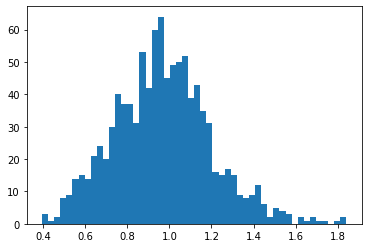

In [15]:
norms=torch.linalg.norm(samples, dim=1).numpy()
plt.hist(norms, bins=50)
plt.show()

In [4]:
from run_lib import get_manifold_dimension

In [5]:
get_manifold_dimension(config)

119it [03:23,  1.71s/it]


In [6]:
path = log_path + log_name + '/svd.pkl'
with open(path, 'rb') as f:
    svd = pickle.load(f)

In [7]:
singular_values = svd['singular_values']

In [8]:
normalized_scores = svd['normalized_scores']

In [9]:
eigen_vals = (np.array(singular_values)**2).mean(axis=0)

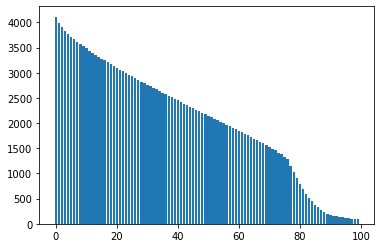

In [16]:
sing_vals = (np.array(singular_values)).mean(axis=0)
plt.bar(list(range(len(sing_vals))),sing_vals)
plt.show()

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components='mle')
pca.fit(normalized_scores.numpy())

PCA(n_components='mle')

In [28]:
pca.n_components_

99

In [29]:
u, s, v = np.linalg.svd(normalized_scores.numpy())

<BarContainer object of 30 artists>

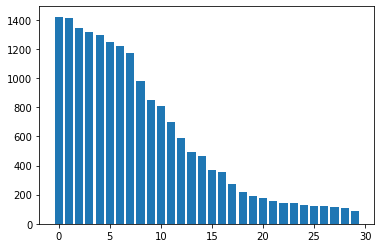

In [31]:
s=s[-30:]
plt.bar(range(len(s)),s)